# CIS6800: Project 3: SOLO and FPN (Instance Segmentation)
### Due:
* Part (a) Oct. 1 at 11:59 p.m.
* Part (b) Oct. 8 at 11:59 p.m.

### Instructions:
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python.
* You may include any code used in previous projects. You may use ChatGPT, but you need to document how you use it.
* You should expect that a complete training session should last about 6 hours, so you should start part (b) as early as you can!
* To save on compute time, we debugging locally and using colab to train. Or use colab cpu instance for debugging
* We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so. You do not, however, need to submit your trained weights.


The SOLO paper: https://arxiv.org/pdf/1912.04488.pdf


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# download data, you can maunally download dataset set here:
# https://drive.google.com/drive/folders/1eP7FtPaWfJ5zLdcsZYl6eyn5EYixkFn8

!gdown --id 1JD3OaHpq_4KCb7ofcPMkknmdEXFHrCcn
!gdown --id 1ssRA7yijGLFmJU-ac-lPyUOq7DYzTAS1
!gdown --id 1Rpz-ZuQxDwvLyzc0FD9GZxAKlyka3VC5
!gdown --id 1ouMFNT1thia8l6P5vcWCY-nweAexLDsB
!pip install pytorch-lightning

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1JD3OaHpq_4KCb7ofcPMkknmdEXFHrCcn
To: /content/hw3_mycocodata_mask_comp_zlib.h5
100% 4.30M/4.30M [00:00<00:00, 42.4MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ssRA7yijGLFmJU-ac-lPyUOq7DYzTAS1
To: /content/hw3_mycocodata_labels_comp_zlib.npy
100% 269k/269k [00:00<00:00, 47.2MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downl

## Code Structure
In this assignment, we are only providing the barest templates for your code structure. If you prefer, you can write and debug most of the components in a regular python and only use Jupyter to train. In this case, you might have several files that you import into this notebook, e.g.
* `dataset.py`
* `model.py`
* `train.py`
* `inference.py`

This is shown below. All files should be included in your submission.

In [ ]:
try:
    import dataset as dt
    import model
    import train
    import inference
    import backbone
except ModuleNotFoundError:
    pass

## Overview

Instance segmentation can be thought of as a combination of object detection and semantic segmentation, the former of which you already explored in the previous project. A visulization of this relationship can be seen in fig. 1.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig1.png" width=500/></div>
<center>Figure 1: An overview of instance segmentation.</center>  

In this project, you are tasked with implementing an instance segmentation framework know as SOLO (Segmenting Object by LOcations). In a similar manner to YOLO, SOLO produces mask predictions on a dense grid. This means that, unlike many other segmenation frameworks (e.g. Mask-RCNN), SOLO directly predicts the segmentation mask without proposing bounding box locations. An visual summary of SOLO can be seen in fig. 2 and 3.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig2.png" width=200/></div>
<center>Figure 2: SOLO.</center>  

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig3.png" width=600/></div>
<center>Figure 3: SOLO branches.</center>

These dense predictions are produced at several different scales using a Feature Pyramid Network (FPN). Using the last few layers of the backbone, we pass the higher level features from the deeper layers back up to larger features scales using lateral connections, shown in fig. 4. The integration of the FPN into your network will be the primary focus of this project.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig4.png" width=300/></div>
<center>Figure 4: SOLO branches.</center>

## Part A

### Dataset
#### Dataset Structure
The dataset used in this project contains three classes across 3265 images: vehicles, people, and animals. The dataset contains the following elements:

* A numpy array of images ($3 \times 300 \times 400$).
* A numpy array of masks ($300 \times 400$).
* A list of ground truth labels by image.
* A list of bounding boxes by image.

Note that the mask array is flattened; to determine which masks belong to which image, count the number of labels associated with that image. For example, if the first few images have 3, 2, and 4 labels, masks 0-2 would belong to image 1, masks 3-4 would belong to image 2, etc. The masks are ordered correctly to allow for this.

#### Loading and Batching
You should apply the following transformations to each image:
* Normalize pixel values to $[0,1]$.
* Rescale the image to $800 \times 1066$.
* Normalize each channel with means $[0.485, 0.456, 0.406]$ and standard deviations $[0.229, 0.224, 0.225]$.
* Zero pad the image to $800 \times 1088$.

Since each image will have a different number of objects, you will have to write your own collation function to properly batch the images. An example collate_fn is shown below, along with expected output dimensions.

In [ ]:
# images:         (batch_size, 3, 800, 1088)
# labels:         list with len: batch_size, each (n_obj,)
# masks:          list with len: batch_size, each (n_obj, 800,1088)
# bounding_boxes: list with len: batch_size, each (n_obj, 4)
def collate_fn(batch):
    images, labels, masks, bounding_boxes = list(zip(*batch))
    return torch.stack(images), labels, masks, bounding_boxes

#### Visualization
In order to validate that you are loading the dataset correct, you should plot at least five example images that include the mask, annotations, and bounding boxes. Examples of such images are shown in fig. 5 and 6. Make sure that the color for each class is consistent!

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig5.png" width=500/></div>
<center>Figure 5: Example visualization.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig6.png" width=500/></div>
<center>Figure 6: Example visualization.</center>

### Model
#### Architecture
The model architecture is summarized in fig. 7 and tables 1 and 2.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig7.png" width=500/></div>
<center>Figure 7: SOLO branch structure.</center>
<br>
<center>Table 1: Category branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 3\times3\times(C-1)$, stride $= 1$, pad $= 1$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note $C = 4$ here (number of classes + background). |

<br>
<center>Table 2: Mask branch structure.</center>

| Layer | Hyperparameters |
| :--- | :--- |
| conv1 | Kernel size $= 3\times3\times(256 + 2)$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Two additional input channels represent the $x$ and $y$ positional encoding. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv2 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv3 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv4 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv5 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv6 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv7 | Kernel size $= 3\times3\times256$, stride $= 1$, pad $= 1$, bias $= \text{False}$. <br> Followed by GroupNorm, num_groups $=32$ and ReLU |
| conv_out | Kernel size $= 1\times1\times(\text{num_grid})^2$, stride $= 1$, pad $= 0$, bias $= \text{True}$. <br> Followed by Sigmoid layer. Note that $\text{num_grid}$ is different for each layer of the FPN. |

We will be using a pretrained backbone (which includes an FPN), so you will not have to implement those components. A template for the network with along with default parameters is shown below.

#### Feature Pyramid
The feature pyramid extracted below has strides $[4,8,16,32,64]$ over the original image. To match the SOLO paper, this should be interpolated to have strides $[8,8,16,32,32]$.

#### Target Assignment
Some notes about generating the ground truth targets:
* The FPN levels can be though of as different grid sizes cut through the image.
* You assign each target to a certain FPN level if $\sqrt{wh}$ from the bounding box falls within the `scale_range` associated with that level. Note that these overlap, so you may assign the same target to multiple levels.
* A grid cell should be considered as predicting an object if that grid cell falls into the "centre region" of the object.
 * The centre region of an object is its bounding box scaled by `epsilon`.
 * Each grid cell can predict at most one object, but each object can be predicted by more than one grid cell.

#### Target Visualization
You should produce visualizations such as fig. 8 and 9 to validate your target assignments.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig8.png" width=500/></div>
<center>Figure 8: Target assignment example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig9.png" width=500/></div>
<center>Figure 9: Target assignment example.</center>

In [ ]:
!pip install pytorch-lightning


In [ ]:
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
import pytorch_lightning as pl

import torch.nn.functional as F
import torch
import torchvision
import pytorch_lightning as pl
from torch import nn
from matplotlib import pyplot as plt
import copy
import numpy as np

In [ ]:
import pdb

In [95]:
class SOLO(pl.LightningModule):
    _default_cfg = {
        'num_classes': 4,
        'in_channels': 256,
        'seg_feat_channels': 256,
        'stacked_convs': 7,
        'strides': [8, 8, 16, 32, 32],
        'scale_ranges': [(1, 96), (48, 192), (96, 384), (192, 768), (384, 2048)],
        'epsilon': 0.2,
        'num_grids': [40, 36, 24, 16, 12],
        'mask_loss_cfg': dict(weight=3),
        'cate_loss_cfg': dict(gamma=2, alpha=0.25, weight=1),
        'postprocess_cfg': dict(cate_thresh=0.2, mask_thresh=0.5, pre_NMS_num=50, keep_instance=5, IoU_thresh=0.5)
    }

    def __init__(self, **kwargs):
        super().__init__()
        for k, v in {**self._default_cfg, **kwargs}.items():
            setattr(self, k, v)

        pretrained_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)
        self.backbone = pretrained_model.backbone

        # category branch
        # repeat 1 - 7 convs
        self.cat_conv_rep = nn.Sequential(
            nn.Conv2d(in_channels= self._default_cfg['in_channels'], out_channels= self._default_cfg['seg_feat_channels'], kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(num_groups=32, num_channels= self._default_cfg['seg_feat_channels']),
            nn.ReLU()
        )

        # conv_out
        self.cat_conv_out = nn.Sequential(
            nn.Conv2d(in_channels= self._default_cfg['seg_feat_channels'], out_channels= self._default_cfg['num_classes'] - 1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.Sigmoid()
            )


        self.category_branch = nn.Sequential()
        for i in range(7):
            self.category_branch.add_module(f"conv_rep_{i+1}", self.cat_conv_rep)
        self.category_branch.add_module("conv_out", self.cat_conv_out)


        # mask branch
        self.mask_conv1 = nn.Sequential(
            nn.Conv2d(in_channels= self._default_cfg['in_channels'] + 2, out_channels= self._default_cfg['seg_feat_channels'], kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(num_groups=32, num_channels= self._default_cfg['seg_feat_channels']),
            nn.ReLU()
        )

        # repeat 2-7 convs
        self.mask_conv2 = nn.Sequential(
            nn.Conv2d(in_channels= self._default_cfg['seg_feat_channels'], out_channels= self._default_cfg['seg_feat_channels'], kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(num_groups=32, num_channels= self._default_cfg['seg_feat_channels']),
            nn.ReLU()
        )

        self.mask_conv_out = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels= self._default_cfg['seg_feat_channels'], out_channels= grid * grid, kernel_size=1, stride=1, padding=0, bias=True),
                nn.Sigmoid()
            ) for grid in self._default_cfg['num_grids']])

        self.mask_branch = nn.Sequential()
        self.mask_branch.add_module("mask_conv1", self.mask_conv1)
        for i in range(6):
            self.mask_branch.add_module(f"mask_conv{i+2}", self.mask_conv2)

        self.mask_branch.add_module("mask_conv_out", self.mask_conv_out)

    # Forward function should calculate across each level of the feature pyramid network.
    # Input:
    #     images: batch_size number of images
    # Output:
    #     if eval = False
    #         category_predictions: list, len(fpn_levels), each (batch_size, C-1, S, S)
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, 2*feature_h, 2*feature_w)
    #     if eval==True
    #         category_predictions: list, len(fpn_levels), each (batch_size, S, S, C-1)
    #         / after point_NMS
    #         mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, image_h/4, image_w/4)
    #         / after upsampling
    def forward(self, images, eval=True):
        # you can modify this if you want to train the backbone
        feature_pyramid = [v.detach() for v in self.backbone(images.float()).values()] # this has strides [4,8,16,32,64]

        #next step is to resize the fpn levels based on the strides in paper
        feature_pyramid = self.NewFPN(feature_pyramid)
        cat_predictions = []
        mask_predictions = []

        #modify categorical branch & get categorical predictions by passing it through architecture
        for i in range(len(feature_pyramid)):
            category_branch_input = nn.functional.interpolate(feature_pyramid[i], size=(self.num_grids[i], self.num_grids[i]), mode='bilinear')
            cat_predictions.append(self.category_branch(category_branch_input))

            #getting mask predictions
            #first we do positional encoding and then pass it through mask architecture defined
            #coordconv is after this function
            mask_branch_input = self.coordconv(feature_pyramid[i])

            mask_branch_output = self.mask_conv1(mask_branch_input)
            for j in range(6):
                mask_branch_output = self.mask_conv2(mask_branch_output)

            mask_branch_output = self.mask_conv_out[i](mask_branch_output)


            #upscale all the feature maps to consistent dimensions
            mask_branch_output = nn.functional.interpolate(mask_branch_output, size=(int(2*800 / self._default_cfg['strides'][i]), int(2*1088 / self._default_cfg['strides'][i])), mode='bilinear')
            #pdb.set_trace()
            mask_predictions.append(mask_branch_output)

        return cat_predictions, mask_predictions

    def NewFPN(self, fpn_feat_list):
    # Resize the 0th and 4th layers of the feature pyramid
        new_fpn_list = [
            F.interpolate(fpn_feat_list[0], scale_factor=0.5),
            fpn_feat_list[1],
            fpn_feat_list[2],
            fpn_feat_list[3],
            F.interpolate(fpn_feat_list[4], size=(25, 34))
        ]
        return new_fpn_list

    def coordconv(self,input):
        #Here we have a 4d input (bs,256,h,w)
        #we have to create a tensor of shape h,w with value bw -1,1 representing the location of x,y pixels
        #y_coord should be [0,0,0],[1,1,1]...
        #to stack it we need to make it 4d again like input shape and then concatenate at end

        bs, channels, image_height, image_width = input.size()

        #repeat the dimensions to be of same shape as original width and height
        y_coords = torch.linspace(-1.0, 1.0, image_height).unsqueeze(-1).repeat(1, image_width)
        x_coords = torch.linspace(-1.0, 1.0, image_width).unsqueeze(0).repeat(image_height, 1)

        # Add batch dimension
        y_coords = y_coords.unsqueeze(0).repeat(bs, 1, 1)
        x_coords = x_coords.unsqueeze(0).repeat(bs, 1, 1)

        # Stack on the channel dimension
        coords = torch.stack([y_coords, x_coords], dim=1).to(input.device)

        # Concatenate with the input
        coord_fpn = torch.cat([coords.to(input.device), input], dim=1)

        return coord_fpn

    # This function build the ground truth tensor for each batch in the training
    # Input:
    #     bounding_boxes:   list, len(batch_size), each (n_object, 4) (x1 y1 x2 y2 system)
    #     labels:           list, len(batch_size), each (n_object, )
    #     masks:            list, len(batch_size), each (n_object, 800, 1088)
    # Output:
    #     category_targets: list, len(batch_size), list, len(fpn), (S, S), values are {1, 2, 3}
    #     mask_targets:     list, len(batch_size), list, len(fpn), (S^2, 2*feature_h, 2*feature_w)
    ##     mask_predictions:     list, len(fpn_levels), each (batch_size, S^2, image_h/4, image_w/4)
    #     active_masks:     list, len(batch_size), list, len(fpn), (S^2,)
    #     / boolean array with positive mask predictions
    def generate_targets(self, bboxes, labels, masks):
            img_height, img_width = 800, 1088
            num_levels = 5
            num_images = len(labels)

            #first we create empty nested lists that will store the final targets for each image
            category_targets = []
            mask_targets = []
            active_masks = []
            active_levels = []

            for _ in range(num_images):
                category_targets.append([[] for i in range(num_levels)])
                mask_targets.append([[] for i in range(num_levels)])
                active_masks.append([[] for i in range(num_levels)])
                active_levels.append([[] for i in range(num_levels)])

            #now lets find the center coordinates for each image and rescale
            for image_idx, img_labels in enumerate(labels):
                current_bboxes = bboxes[image_idx]

                x1, y1, x2, y2 = current_bboxes[:, 0], current_bboxes[:, 1], current_bboxes[:, 2], current_bboxes[:, 3]
                x_center = (x1 + x2) / 2
                y_center = (y1 + y2) / 2
                width_bbox = x2 - x1
                height_bbox = y2 - y1
                diag_bbox = torch.sqrt(width_bbox * height_bbox)

                width_centered = width_bbox * self._default_cfg['epsilon']
                height_centered = height_bbox * self._default_cfg['epsilon']
                x1_center = x_center - width_centered / 2
                y1_center = y_center - height_centered / 2
                x2_center = x_center + width_centered / 2
                y2_center = y_center + height_centered / 2

                #Now we go over each bounding boxes (objects) and based on diagbbox value, we check which FPN does it
                for obj_idx, obj_bbox in enumerate(bboxes[image_idx]):
                    assigned_levels = []
                    for idx, lim in enumerate(self._default_cfg['scale_ranges']):
                        if lim[0] <= diag_bbox[obj_idx] <= lim[1]:
                            assigned_levels.append(idx)

                    #now for each fpn level that an object belongs to, we need to see the specific cells predict the object
                    for level in assigned_levels:
                        active_levels[image_idx][level] = 1.0
                        h_cell = img_height / self._default_cfg['num_grids'][level]
                        w_cell = img_width / self._default_cfg['num_grids'][level]
                        grid = torch.zeros((self._default_cfg['num_grids'][level], self._default_cfg['num_grids'][level]))

                        x_start = int(x1_center[obj_idx] / w_cell)
                        y_start = int(y1_center[obj_idx] / h_cell)
                        x_end = int(x2_center[obj_idx] / w_cell)
                        y_end = int(y2_center[obj_idx] / h_cell)

                        for x_val in torch.arange(x_start, x_end + 1):
                            for y_val in torch.arange(y_start, y_end + 1):
                                grid[x_val][y_val] = img_labels[obj_idx]

                        category_targets[image_idx][level].append(grid)

                        #we calculate adjusted feature maps
                        feature_height = img_height/self._default_cfg['strides'][level]
                        feature_width = img_width/self._default_cfg['strides'][level]

                        # we add dimensions to our mask and perform bilinear interpolation followed by binary masking
                        mask_clone = masks[image_idx][obj_idx].clone().to(device)
                        mask_rescaled = F.interpolate(mask_clone.unsqueeze(0).unsqueeze(0), size=(int(2*feature_height), int(2*feature_width)), mode='bilinear').squeeze(0).squeeze(0)
                        mask_rescaled = (mask_rescaled > 0.5).float().to(device)
                        #pdb.set_trace()
                        mask_tensor = torch.zeros(int(grid.shape[0]*grid.shape[1]), int(2*feature_height), int(2*feature_width))
                        mask_tensor = mask_tensor.to(device)
                        grid_flat = grid.flatten().to(device)

                        idx = torch.argwhere(grid_flat>0)
                        mask_tensor[idx, :, :] = mask_rescaled

                        #print(mask_drawer)
                        mask_targets[image_idx][level].append(mask_tensor)

                        #Create a binary tensor marking the cells where the object is present.
                        activation = torch.zeros_like(grid_flat)
                        #activation[active_idx] = 1
                        activation[idx] = 1
                        active_masks[image_idx][level].append(activation)
                        #pdb.set_trace()


            category_targets, mask_targets, active_masks = self.fill_empty_tensors(category_targets, mask_targets, active_masks)
            #pdb.set_trace()
            return category_targets, mask_targets, active_masks, active_levels


    def fill_empty_tensors(self, category_targets, mask_targets, active_masks):
        #In this function, we iterate through each fpn levels of each image. If the three output lists are empty, we initialize zero tensors based on the expected output dimensions given to us
            num_grids = self._default_cfg['num_grids']
            strides = self._default_cfg['strides']

            for img_id, (categories, masks, actives) in enumerate(zip(category_targets, mask_targets, active_masks)):
                for fpn_lev in range(5):
                    #if the value exists in the list, we keep it the same else we define zero tensors of appropriate shapes
                    category_targets[img_id][fpn_lev] = categories[fpn_lev] or [torch.zeros((num_grids[fpn_lev], num_grids[fpn_lev]))]
                    mask_targets[img_id][fpn_lev] = masks[fpn_lev] or [torch.zeros((num_grids[fpn_lev] * num_grids[fpn_lev], 2 * 800 // strides[fpn_lev], 2 * 1088 // strides[fpn_lev]))]
                    active_masks[img_id][fpn_lev] = actives[fpn_lev] or [torch.zeros((num_grids[fpn_lev] * num_grids[fpn_lev]))]

            return category_targets, mask_targets, active_masks



    def visualize_fpn(self, images, category_targets, mask_targets_list, active_masks):
        pic_count = len(images)
        level_count = 5

        for pic_idx in range(pic_count):
            fig, axes = plt.subplots(1, level_count, figsize=(15, 3))  # Adjust figsize as needed
            for lvl in range(level_count):
                axis = axes[lvl]
                axis.set_title(f"FPN Level: {lvl}")
                pic_data = images[pic_idx].detach().cpu().permute(1, 2, 0).numpy()
                axis.imshow(pic_data)

                level_cat_targets = category_targets[pic_idx][lvl]
                level_mask_targets = mask_targets_list[pic_idx][lvl]
                level_active_masks = active_masks[pic_idx][lvl]

                if level_cat_targets:
                    for lbl, clr in zip([1, 2, 3], [(1, 0, 0), (0, 1, 0), (0, 0, 1)]):  # red, green, blue
                        obj_idxs = torch.where(level_cat_targets[0] == lbl)
                        if obj_idxs[0].shape[0] > 0:
                            mask_aggregate = torch.sum(level_mask_targets[0][obj_idxs[0] * self._default_cfg['num_grids'][lvl] + obj_idxs[1]], axis=0)
                            mask_aggregate = torch.clamp(mask_aggregate, 0, 1).unsqueeze(0).unsqueeze(0)
                            resized_aggregate = F.interpolate(mask_aggregate, size=(800, 1088), mode='nearest').squeeze(0).squeeze(0)
                            clr_mask = torch.stack((resized_aggregate, resized_aggregate, resized_aggregate), axis=0)
                            clr_mask[0, :, :] = clr[0]
                            clr_mask[1, :, :] = clr[1]
                            clr_mask[2, :, :] = clr[2]
                            axis.imshow(clr_mask.permute(1, 2, 0).detach().cpu().numpy(), alpha=0.4)

            plt.tight_layout()
            plt.show()


    def total_loss(self,cat_predictions,mask_predictions, cat_targets, mask_targets,active_masks, active_levels):
        ### total loss = lambda_cat*categorical_loss + lambda_mask*mask_loss

        category_loss = self.category_loss(cat_predictions, cat_targets, active_levels)
        mask_loss = self.mask_loss(mask_predictions, mask_targets, active_masks, active_levels)
        loss = (self._default_cfg['cate_loss_cfg']['weight']*category_loss) + (self._default_cfg['mask_loss_cfg']['weight']*mask_loss)
        #pdb.set_trace()
        return loss,category_loss,mask_loss


    def category_loss(self,cat_predictions, cat_targets,active_levels):
        #alpha, gamma are stored in _default_cfg dictionary under key cate_loss_cfg
        alpha = self._default_cfg['cate_loss_cfg']['alpha']
        gamma = self._default_cfg['cate_loss_cfg']['gamma']
        num_grids = self._default_cfg['num_grids']
        classes = self._default_cfg['num_classes']
        total_loss = []
        #pdb.set_trace()
        # go over all images
        for target_num, target in enumerate(cat_targets):
            level_losses = []
            #go over all fpn levels (5 levels)
            for grid_idx, grid_size in enumerate(num_grids):
                object_loss, background_loss = 0, 0
                #Since each grid can contain either of 3 classes, we find the prob of a grid having a category
                for category in [1, 2, 3]:
                    #predictions are stored for 0th class,1st class and 2nd class sequentially
                    p_hat = cat_predictions[grid_idx][target_num][category - 1, :, :].to(device)
                    #print("p_hat min:", p_hat.min(), "p_hat max:", p_hat.max())
                    #we go over each pixel of grid and see if the value is same as target, we put a 1 else 0. This is how we create a binary mask
                    #pdb.set_trace(0)
                    category_mask = target[grid_idx][0].to(device)

                    #print("target_num",target_num)
                    #print("grid_idx",grid_idx)
                    #print("category",category)



                    #if the fpn level is active, we calculate the focal loss for both objects and background
                    #else we just calculate the focal loss for background
                    if active_levels[target_num][grid_idx]:
                        object_focal_loss, background_focal_loss = self.compute_focal_loss(alpha, gamma, p_hat, category_mask)
                        #add both losses
                        object_loss += torch.sum(object_focal_loss)
                        #print("obj loss after adding",object_loss)
                        background_loss += torch.sum(background_focal_loss)
                        #print("bg loss after adding",background_loss )
                    else:
                        #add only background focal loss ( we use 1-alpha as alpha according to instructions)
                        background_loss += torch.sum(-1 * (1 - alpha) * torch.pow(1 - (1 - p_hat), gamma) * torch.log(1 - p_hat))
                        #print("level not active . adding bg loss", background_loss)
                #find average loss across that fpn level
                #print("level_losses", level_losses)
                level_losses.append((object_loss + background_loss) / (grid_size * grid_size * classes))
            #average loss over all fpn levels
            level_losses = torch.stack(level_losses)
            total_loss.append(torch.mean(level_losses))
            #print("total_loss",total_loss)
        #average loss over all targets
        total_loss = torch.stack(total_loss)
        #print("categorical loss", torch.mean(total_loss))
        return torch.mean(total_loss)

    def compute_focal_loss(self, alpha,gamma,p_hat,category_mask):
        #if prediction prob for object =1 , we use alpha = alpha, phat = phat
        #else alpha = 1-alpha, phat = 1-phat
        epsilon = 1e-7
        pos_prediction = -1 * alpha * torch.pow(1 - p_hat, gamma) * torch.log(p_hat + epsilon)
        neg_prediction = -1 * (1 - alpha) * torch.pow(p_hat, gamma) * torch.log(1 - p_hat + epsilon)

        #now we simply apply these losses to cells where target is present (indicated by our binary mask)
        object_focal_loss = pos_prediction * category_mask
        #background loss should be multiplied where there is false in binary mask
        background_focal_loss = neg_prediction  * (1 - category_mask)

        return object_focal_loss,background_focal_loss

    def mask_loss(self, mask_predictions, mask_targets, active_mask, active_level):
            total_mask_loss = []
            # Iterate over each target using range
            for target_idx in range(len(mask_targets)):
                loss_curr = []
                # Go over each FPN level using range
                for level_idx in range(len(self._default_cfg['num_grids'])):
                    #print("target_idx: ", target_idx)
                    #print("level_idx: ", level_idx)

                    # if the current grid is active, we extract the active masks and compute dice loss
                    if active_level[target_idx][level_idx]:
                        active_flags = active_mask[target_idx][level_idx][0].bool()
                        # active_flags[:, None, None]
                        #active_flags = active_flags.bool()
                        #pdb.set_trace()

                        # dice loss calculated between predicted and target mask
                        current_loss = self.dice_loss(mask_predictions[level_idx][target_idx][active_flags], mask_targets[target_idx][level_idx][0][active_flags])

                        #print("current_loss: ", current_loss)
                        loss_curr.append(torch.mean(current_loss))

                total_mask_loss.append(torch.mean(torch.stack(loss_curr)))

            return torch.mean(torch.stack(total_mask_loss))

    def dice_loss(self,mask_predictions, mask_target):

        # we will add small value in both numerator and denominator to avoid 0/0 division
        epsilon = 1e-5
        #we flatten so that taking sum is feasible in numr,denr
        flattened_pred = mask_predictions.view(-1)
        flattened_target = mask_target.view(-1)
        #print("flattened_pred",flattened_pred.shape)
        #print("flattened_target",flattened_target.shape)

        numerator = (flattened_pred * flattened_target).sum()
        dice_coefficient = (2. * numerator + epsilon) / (torch.sum(flattened_pred ** 2) + torch.sum(flattened_target ** 2) + epsilon)
        return 1 - dice_coefficient


    def training_step(self,batch,batch_idx):
        #since we are using lightning module, we need to define training for each batch

        images, labels,masks, bounding_boxes = batch
        images = images.to(device)
        labels = [label.to(device) for label in labels]
        masks = [mask.to(device) for mask in masks]
        bounding_boxes = [bbox.to(device) for bbox in bounding_boxes]

        # Forward pass
        cat_predictions, mask_predictions = self.forward(images)
        #print("mask_predictions",mask_predictions)
        #transformed_labels = [(label_tensor.sum(dim=[1, 2]) > 0).nonzero().squeeze(-1) for label_tensor in labels]

        # Generate targets
        #category_targets, mask_targets, active_masks, active_levels = self.generate_targets(bounding_boxes, transformed_labels, masks)

        cat_targets, mask_targets, active_masks, active_levels = self.generate_targets(bounding_boxes, labels, masks)
        #cat_targets, mask_targets, active_masks = model.fill_empty_tensors(cat_targets, mask_targets, active_masks)

        # Compute loss
        loss, category_loss, mask_loss = self.total_loss(cat_predictions, mask_predictions, cat_targets, mask_targets, active_masks, active_levels)
        self.log("training_loss", loss, prog_bar=True,on_epoch=True)
        self.log("training_category_loss", category_loss, prog_bar=True,on_epoch=True)
        self.log("training_mask_loss", mask_loss, prog_bar=True,on_epoch=True)

        return loss

    def configure_optimizers(self):
        optimizer =  torch.optim.SGD(self.parameters(), lr=0.01,  momentum=0.9, weight_decay=1e-4)
        # it is told that lr should decrease on 27th, 33rd epoch by a factor of 10
        scheduler = {'scheduler': torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[27, 33], gamma=0.1),'interval': 'epoch',  'frequency': 1 }
        return [optimizer], [scheduler]

    def validation_step(self,batch,batch_idx):
        #since we are using lightning module, we need to define training for each batch
        #print("inside validation")
        images, labels,masks, bounding_boxes = batch
        images = images.to(device)
        labels = [label.to(device) for label in labels]
        masks = [mask.to(device) for mask in masks]
        bounding_boxes = [bbox.to(device) for bbox in bounding_boxes]
        cat_predictions, mask_predictions = self.forward(images)
        cat_targets, mask_targets, active_masks, active_levels = self.generate_targets(bounding_boxes, labels, masks)
        cat_targets, mask_targets, active_masks = model.fill_empty_tensors(cat_targets, mask_targets, active_masks)

        # Compute loss
        # since we are logging losses by diff strings, it is ok to use same variable name
        loss, category_loss, mask_loss = self.total_loss(cat_predictions, mask_predictions, cat_targets, mask_targets, active_masks, active_levels)
        self.log("validation_loss", loss, prog_bar=True,on_epoch=True)
        self.log("validation_category_loss", category_loss, prog_bar=True,on_epoch=True)
        self.log("validation_mask_loss", mask_loss, prog_bar=True,on_epoch=True)
        return loss

In [93]:
imgs_path = '/content/drive/MyDrive/cis680/hw3_mycocodata_img_comp_zlib.h5'
masks_path = '/content/drive/MyDrive/cis680/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = "/content/drive/MyDrive/cis680/hw3_mycocodata_labels_comp_zlib.npy"
bboxes_path = "/content/drive/MyDrive/cis680/hw3_mycocodata_bboxes_comp_zlib.npy"

#imgs_path = '/content/drive/MyDrive/classwork/cis680/homework/hw3 solo/hw3_mycocodata_img_comp_zlib.h5'
#masks_path = '/content/drive/MyDrive/classwork/cis680/homework/hw3 solo/hw3_mycocodata_mask_comp_zlib.h5'
#labels_path = "/content/drive/MyDrive/classwork/cis680/homework/hw3 solo/hw3_mycocodata_labels_comp_zlib.npy"
#bboxes_path = "/content/drive/MyDrive/classwork/cis680/homework/hw3 solo/hw3_mycocodata_bboxes_comp_zlib.npy"
paths = [imgs_path, masks_path, labels_path, bboxes_path]


# Load the data into data.Dataset
d = dt.BuildDataset(paths)

full_size = len(d)
train_size = int(full_size * 0.9)
test_size = full_size - train_size
torch.random.manual_seed(1)
train_dataset, test_dataset = torch.utils.data.random_split(d, [train_size, test_size])


# Create DataLoaders
batch_size = 16
train_build_loader = dt.BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()


val_build_loader = dt.BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers = 0)
val_loader = val_build_loader.loader()

iter_loader = iter(train_loader)
batch = next(iter_loader)
images, labels, masks, bounding_boxes = batch
images = images.to(device)
labels = [label.to(device) for label in labels]
masks = [mask.to(device) for mask in masks]
bounding_boxes = [bbox.to(device) for bbox in bounding_boxes]


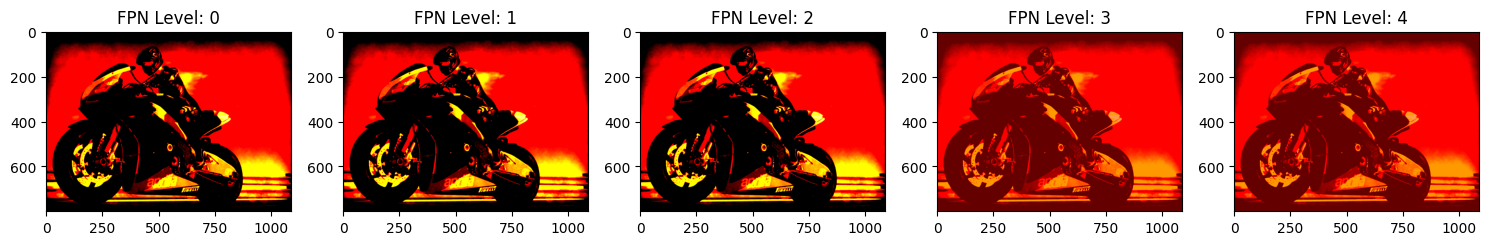

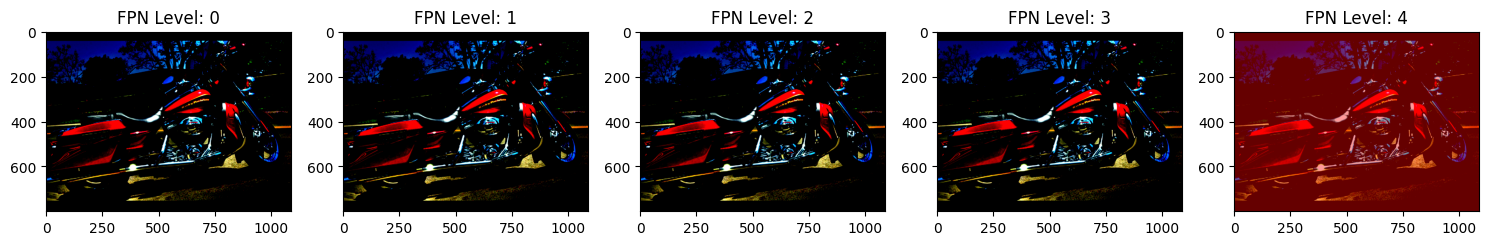

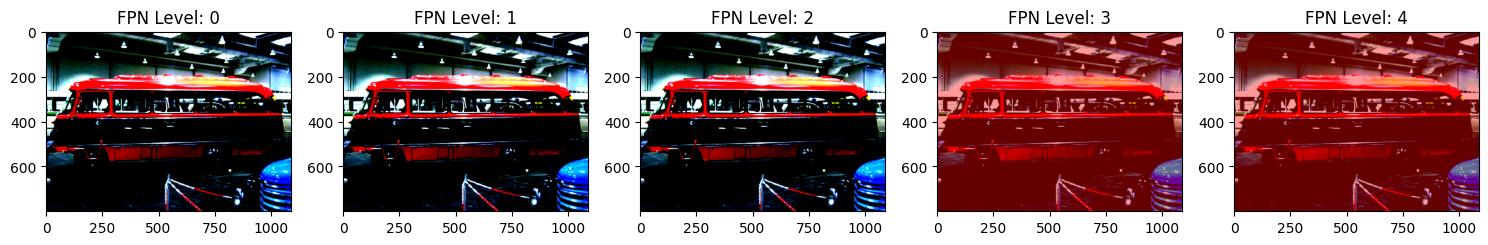

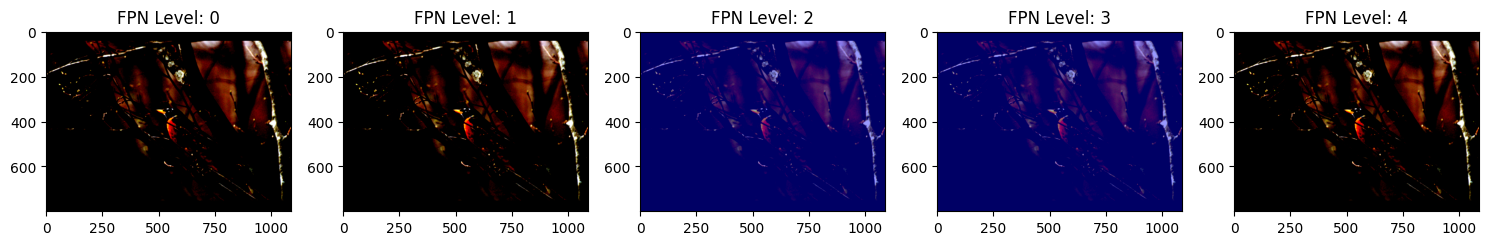

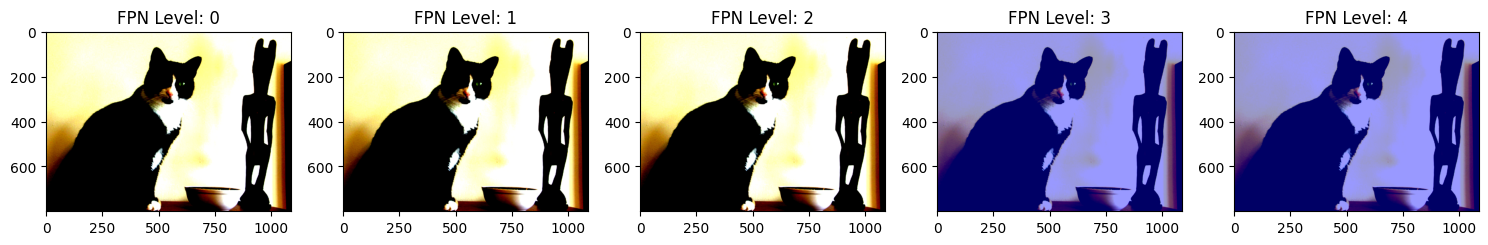

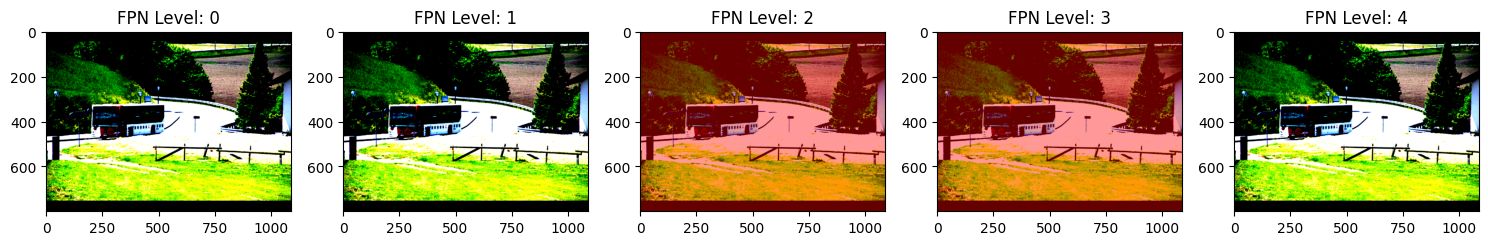

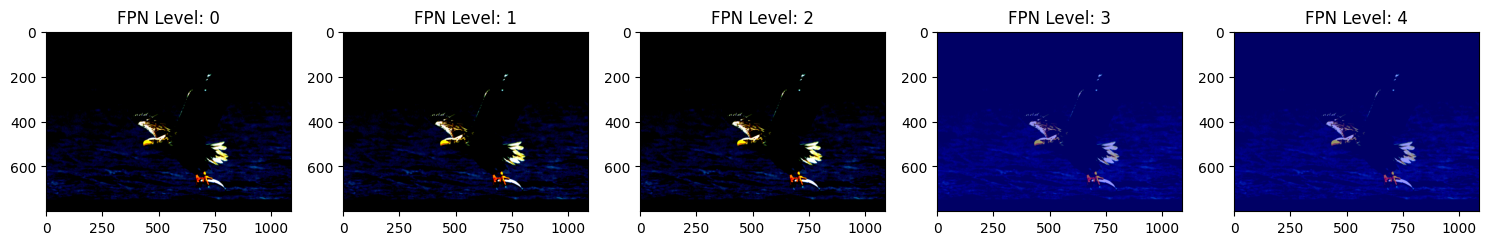

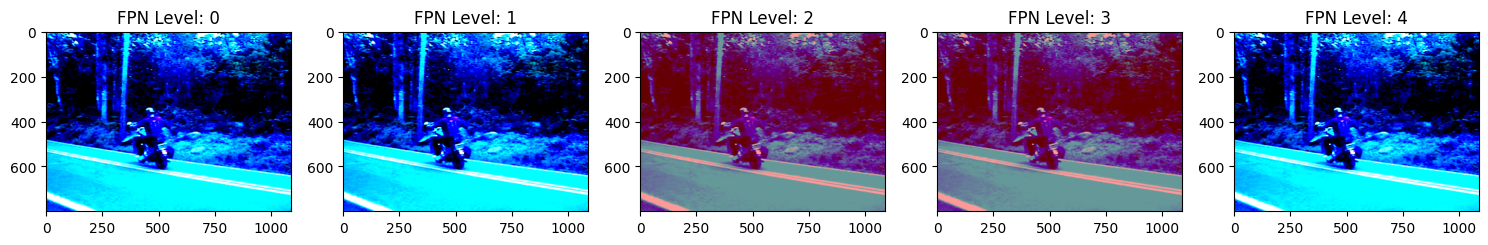

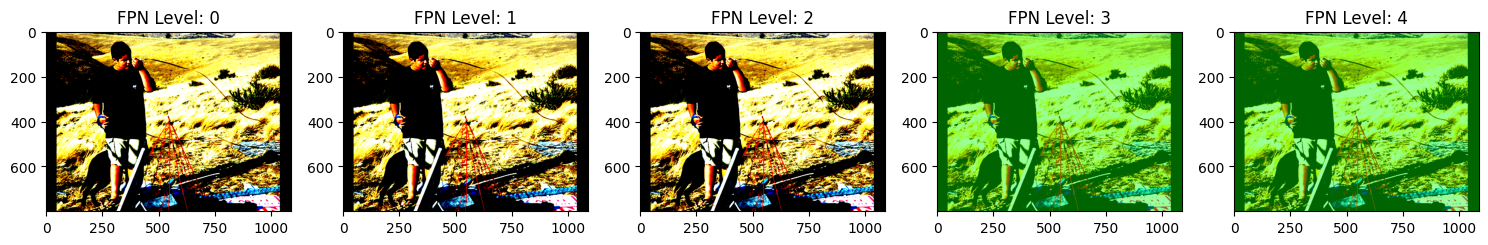

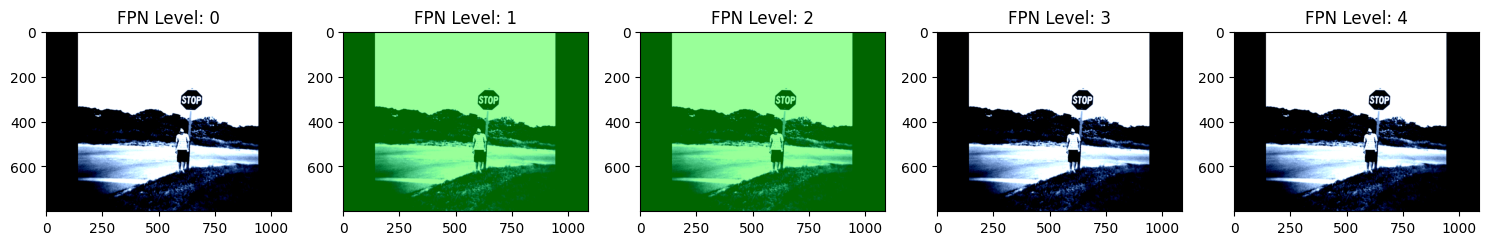

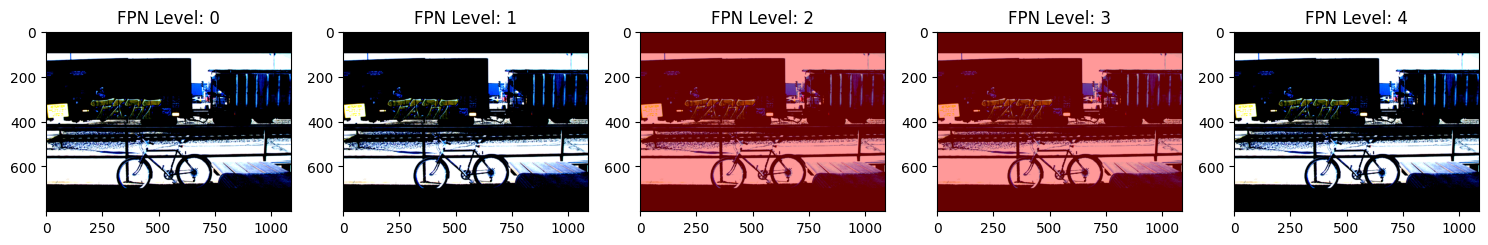

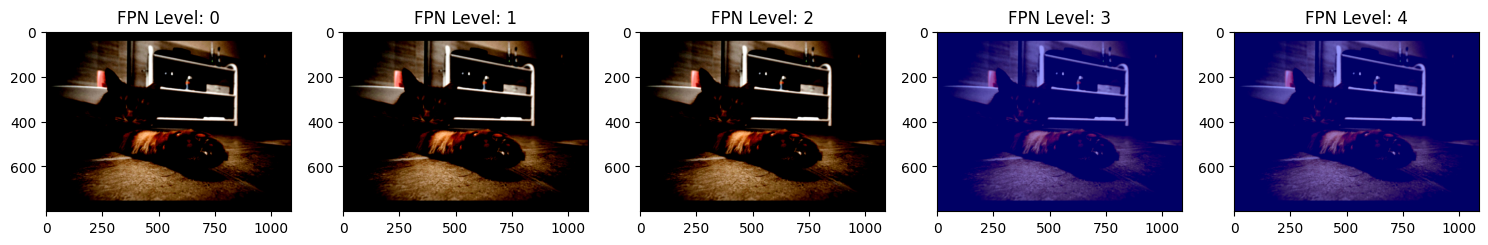

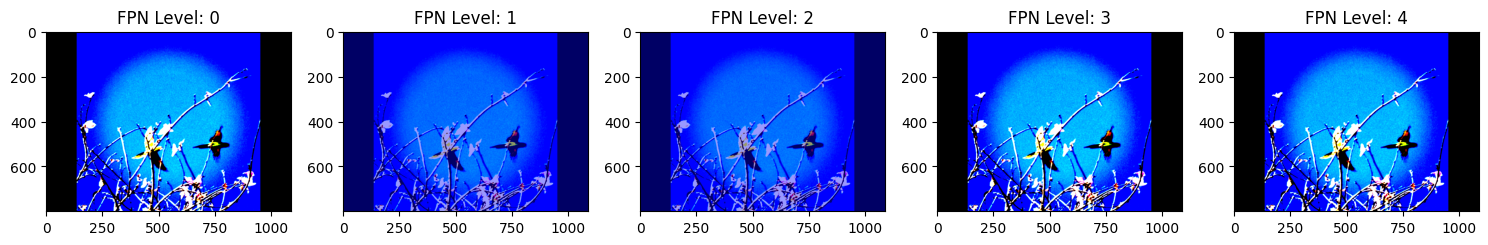

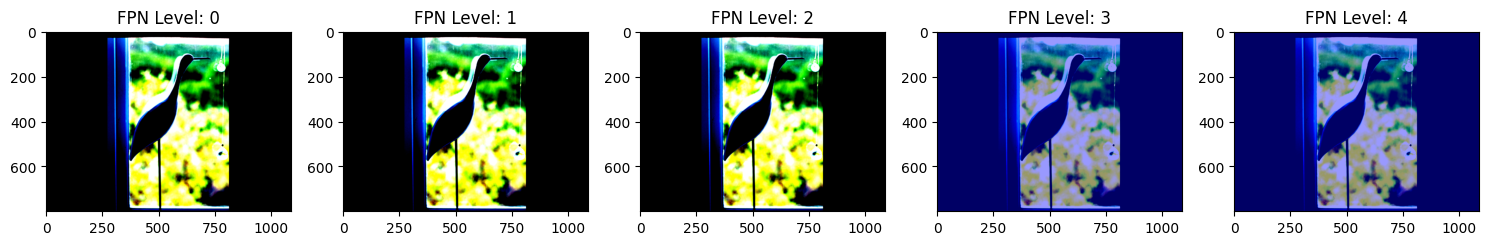

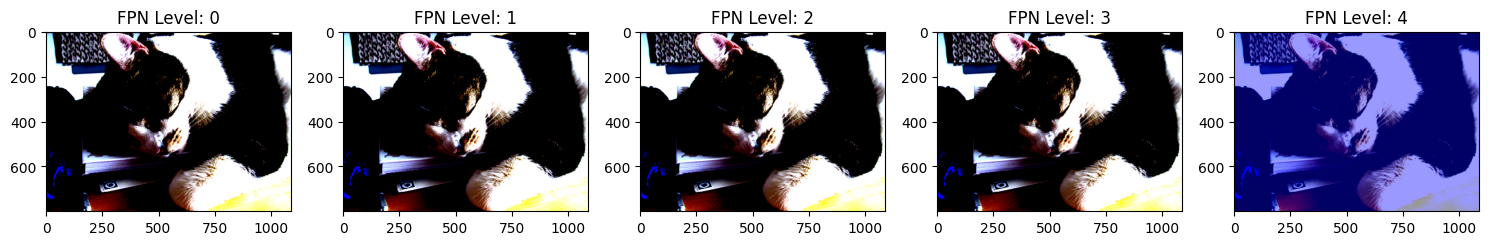

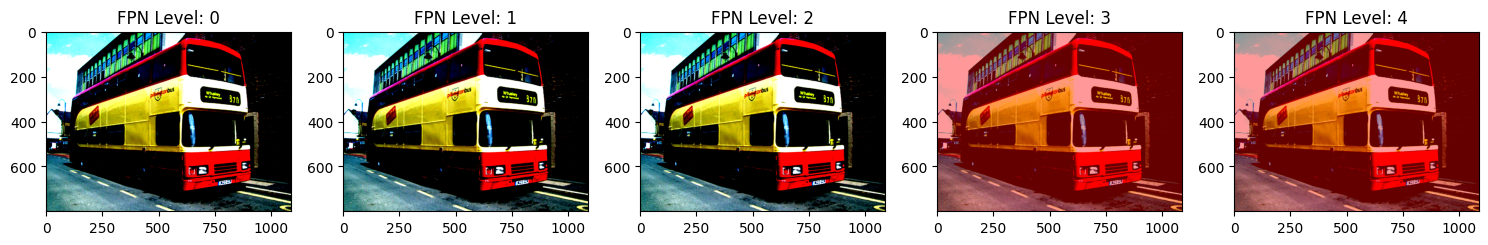

In [96]:
model = SOLO()

category_targets, mask_targets, active_masks, _ = model.generate_targets(batch[3], batch[1], batch[2])
category_targets, mask_targets, active_masks = model.fill_empty_tensors(category_targets, mask_targets, active_masks)
model.visualize_fpn(batch[0], category_targets, mask_targets,active_masks)

In [ ]:
import os

#creating folders for storing checkpoints and loss logs
checkpoint_dir = './checkpoints'
logs_dir = './logs'

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)

In [ ]:
#it has been told to use checkpointing
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.loggers import TensorBoardLogger



# we will monitor validation loss store checkpoints in the directory /checkpoints fodler.
# we want to minimze val loss

#we will also use csv logger to log loss and val loss after each epoch so that we can plot it later
tensorboard = TensorBoardLogger(save_dir='/content/drive/MyDrive/cis680/logs', name='solo_logs')
csv_logger = CSVLogger(save_dir='/content/drive/MyDrive/cis680/logs', name='solo_csv_logs')

checkpoint = ModelCheckpoint(
    monitor='validation_loss',
    dirpath='/content/drive/MyDrive/cis680/checkpoints',
    filename='solo-best-{epoch:02d}-{validation_loss:.2f}',
    save_top_k=1,
    mode='min',
    save_weights_only=False,
    verbose = True
)

model = SOLO().to(device)
print(model.device)

trainer = pl.Trainer(max_epochs=15,callbacks=[checkpoint],logger=[tensorboard,csv_logger])
trainer.fit(model, train_loader, val_loader)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

cuda:0


INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type            | Params
----------------------------------------------------
0 | backbone        | BackboneWithFPN | 26.8 M
1 | cat_conv_rep    | Sequential      | 590 K 
2 | cat_conv_out    | Sequential      | 6.9 K 
3 | category_branch | Sequential      | 597 K 
4 | mask_conv1      | Sequential      | 594 K 
5 | mask_conv2      | Sequential      | 590 K 
6 | mask_conv_out   | ModuleList      | 995 K 
7 | mask_branch     | Sequential   

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightn

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 10. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 7. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 184: 'validation_loss' reached 1.29921 (best 1.29921), saving model to '/content/drive/MyDrive/cis680/checkpoints/solo-best-epoch=00-validation_loss=1.30.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 368: 'validation_loss' reached 1.14040 (best 1.14040), saving model to '/content/drive/MyDrive/cis680/checkpoints/solo-best-epoch=01-validation_loss=1.14.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 552: 'validation_loss' reached 1.04554 (best 1.04554), saving model to '/content/drive/MyDrive/cis680/checkpoints/solo-best-epoch=02-validation_loss=1.05.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 736: 'validation_loss' reached 1.00878 (best 1.00878), saving model to '/content/drive/MyDrive/cis680/checkpoints/solo-best-epoch=03-validation_loss=1.01.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 920: 'validation_loss' reached 0.95976 (best 0.95976), saving model to '/content/drive/MyDrive/cis680/checkpoints/solo-best-epoch=04-validation_loss=0.96.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1104: 'validation_loss' reached 0.93586 (best 0.93586), saving model to '/content/drive/MyDrive/cis680/checkpoints/solo-best-epoch=05-validation_loss=0.94.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 1288: 'validation_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 1472: 'validation_loss' reached 0.89372 (best 0.89372), saving model to '/content/drive/MyDrive/cis680/checkpoints/solo-best-epoch=07-validation_loss=0.89.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 1656: 'validation_loss' reached 0.86871 (best 0.86871), saving model to '/content/drive/MyDrive/cis680/checkpoints/solo-best-epoch=08-validation_loss=0.87.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 1840: 'validation_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 2024: 'validation_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 2208: 'validation_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 2392: 'validation_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 2576: 'validation_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 2760: 'validation_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


# if i want to Load model and do further training


In [ ]:
"""
# Load model and do further training
model = SOLO.load_from_checkpoint("/content/checkpoints/solo-best-epoch=01-validation_loss=1.07.ckpt")

# Callbacks and Loggers
tensorboard = TensorBoardLogger(save_dir='./logs', name='solo_logs')
csv_logger = CSVLogger(save_dir='./logs', name='solo_csv_logs')

checkpoint = ModelCheckpoint(
    monitor='validation_loss',
    dirpath='./checkpoints',
    filename='solo-best-{epoch:02d}-{validation_loss:.2f}',
    save_top_k=1,
    mode='min',
    save_weights_only=False,
    verbose=True
)

trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[checkpoint],
    logger=[tensorboard, csv_logger],
    resume_from_checkpoint="path_to_your_checkpoint.ckpt" # Path to the checkpoint
)

trainer.fit(model, train_loader, val_loader)
"""

# if i want to load model from checkpoint for inference


In [ ]:
"""
# load model from checkpoint for inference
model = SOLO.load_from_checkpoint("solo-best-epoch=01-validation_loss=1.07.ckpt")
model.eval()
model = model.to(device)
"""

'\n# load model from checkpoint for inference\nmodel = SOLO.load_from_checkpoint("solo-best-epoch=01-validation_loss=1.07.ckpt")\nmodel.eval()\nmodel = model.to(device)\n'

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/cis680/logs/solo_csv_logs/version_1/metrics.csv')
df.head(4)

training_loss_step  training_category_loss_step  training_mask_loss_step  \
0            1.281195                     0.007749                 0.424482   
1            1.555207                     0.005760                 0.516482   
2            1.281266                     0.004561                 0.425568   
3                 NaN                          NaN                      NaN   

   epoch  step  validation_loss  validation_category_loss  \
0      0    49              NaN                       NaN   
1      0    99              NaN                       NaN   
2      0   149              NaN                       NaN   
3      0   183         1.299213                  0.004761   

   validation_mask_loss  training_loss_epoch  training_category_loss_epoch  \
0                   NaN                  NaN                           NaN   
1                   NaN                  NaN                           NaN   
2                   NaN                  NaN                           NaN   
3              0.431484                  NaN                           NaN   

   training_mask_loss_epoch  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN

### For each epoch, when the model is on training data, it fills the training columns . For validation, it fills the validation columns. This is how CSV logger naturally works. So to visualize we will group by epoch and take avg

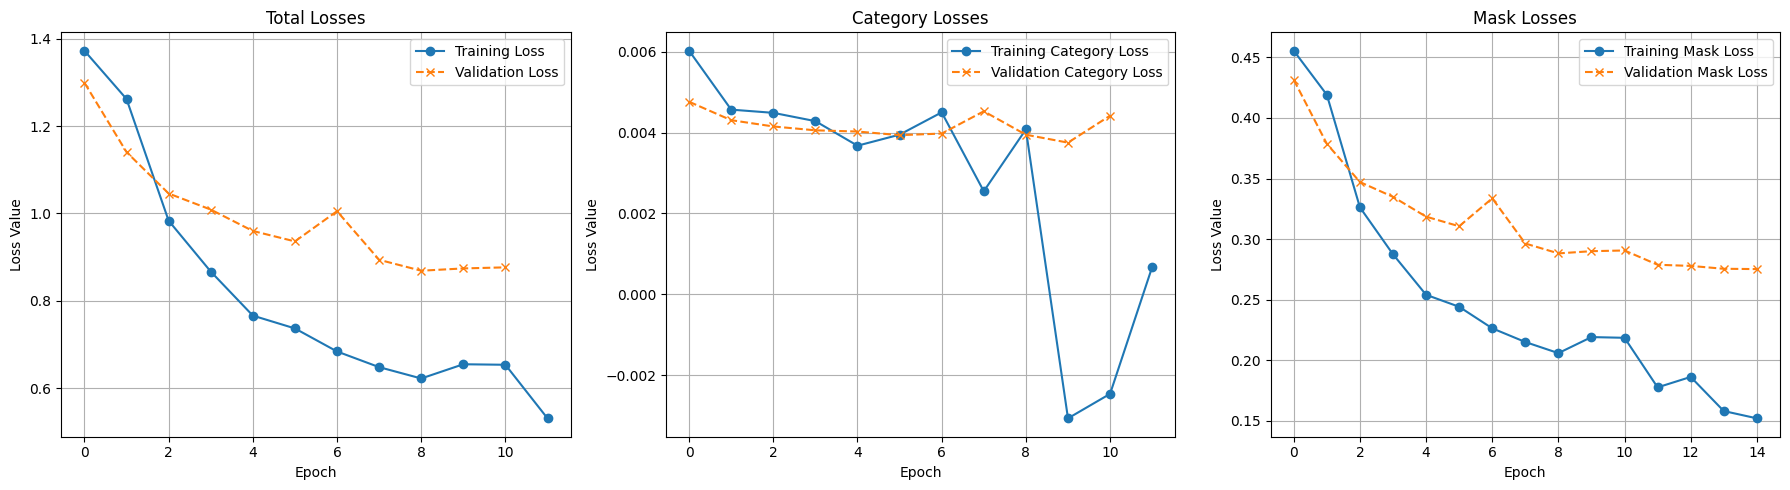

In [ ]:
grouped = df.groupby('epoch').mean()


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Training losses
axes[0].plot(grouped.index, grouped['training_loss_step'], label='Training Loss', marker='o', linestyle='-')
axes[0].plot(grouped.index, grouped['validation_loss'], label='Validation Loss', marker='x', linestyle='--')
axes[0].set_title('Total Losses')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss Value')
axes[0].legend()
axes[0].grid(True)

# Category losses
axes[1].plot(grouped.index, grouped['training_category_loss_step'], label='Training Category Loss', marker='o', linestyle='-')
axes[1].plot(grouped.index, grouped['validation_category_loss'], label='Validation Category Loss', marker='x', linestyle='--')
axes[1].set_title('Category Losses')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss Value')
axes[1].legend()
axes[1].grid(True)

# Mask losses
axes[2].plot(grouped.index, grouped['training_mask_loss_step'], label='Training Mask Loss', marker='o', linestyle='-')
axes[2].plot(grouped.index, grouped['validation_mask_loss'], label='Validation Mask Loss', marker='x', linestyle='--')
axes[2].set_title('Mask Losses')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss Value')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


### Part A Submission
In addition to the code you used, you should submit a pdf containing the following plots:
* Dataset visualization plots such as fig. 5 and 6. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Target assignment plots such as fig. 8 and 9. Should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.

We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so.

## Part B
### Loss
The loss function consists of two parts: category loss and mask loss:
$$L = \lambda_\text{cate} L_\text{cate} + \lambda_\text{mask} L_\text{mask} $$

The category loss is defined as (where $\text{FL}$ is the focal loss)

$$L_\text{cate} = \frac{1}{S^2 C} \sum_{S,S,C} \text{FL}(p_t)$$

$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^\gamma \log{(p_t)}$$

$$(\alpha_t, p_t) = \left\{\begin{array}{lr} (\alpha, \hat{p}) & \text{if }y=1 \\ (1 - \alpha, 1 - \hat{p}) & \text{otherwise}\end{array}\right.$$

while the mask loss is defined as (where $d_\text{mask}$ is the dice loss)

$$L_\text{mask} = \frac{1}{N_\text{positive}} \sum_k \mathbb{1}_{\{p_{i, j} > 0\}} d_\text{mask}(m_k, \hat{m}_k)$$

$$d_\text{mask}(p, q) = 1 - D(p, q)$$

$$D(p, q) = \frac{2 \sum_{x,y}(p_{x,y} \cdot q_{x,y})}{\sum_{x,y}p_{x,y}^2 + \sum_{x,y}q_{x,y}^2}$$

### Post Processing
Post processing consists of three steps: points NMS, concatenation and sorting, and matrix NMS. A summary of each of these steps is provided below. In addition, your final mask prediction should be a binary mask based on the mask thresholding parameter. Some examples of results post-inference are shown in figs. 11-14.


<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig11.png" width=300/></div>
<center>Figure 11: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig12.png" width=300/></div>
<center>Figure 12: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig13.png" width=300/></div>
<center>Figure 13: SOLO instance segmentation example.</center>

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW3/fig14.png" width=300/></div>
<center>Figure 14: SOLO instance segmentation example.</center>

#### Points NMS
Non-max suppression for the category predictions, applied to each channel sperately. A maxpooling with a kernel size of 2, sample code is included below.

#### Concatenation and Sorting
Here, we merge the predictions across all the FPN levels into a single list of predictions, sorted by their predicted score. This involves rescaling the predicted masks appropriately.

#### Matrix NMS
Inspired by Soft-NMS, MatrixNMS suppresses mask predictions with a lower score based on their similarity to predictions with a higher score in a completely vectorized manner. Sample code is include below.

In [ ]:
# Credit to SOLO Author's code
# This function does NMS on the heat map (category_prediction), grid-level
# Input:
#     heat: (batch_size, C-1, S, S)
# Output:
#     (batch_size, C-1, S, S)
def points_nms(heat, kernel=2):
    # kernel must be 2
    hmax = F.max_pool2d(
        heat, (kernel, kernel), stride=1, padding=1)
    keep = (hmax[:, :, :-1, :-1] == heat).float()
    return heat * keep

# This function performs Matrix NMS
# Input:
#     sorted_masks: (n_active, image_h/4, image_w/4)
#     sorted_scores: (n_active,)
# Output:
#     decay_scores: (n_active,)
def MatrixNMS(sorted_masks, sorted_scores, method='gauss', gauss_sigma=0.5):
    n = len(sorted_scores)
    sorted_masks = sorted_masks.reshape(n, -1)
    intersection = torch.mm(sorted_masks, sorted_masks.T)
    areas = sorted_masks.sum(dim=1).expand(n, n)
    union = areas + areas.T - intersection
    ious = (intersection / union).triu(diagonal=1)

    ious_cmax = ious.max(0)[0].expand(n, n).T
    if method == 'gauss':
        decay = torch.exp(-(ious ** 2 - ious_cmax ** 2) / gauss_sigma)
    else:
        decay = (1 - ious) / (1 - ious_cmax)
    decay = decay.min(dim=0)[0]
    return sorted_scores * decay

In [ ]:
iter_loader = iter(val_loader)
test_batch = next(iter_loader)
test_images = test_batch[0].to(model.device)

with torch.no_grad():
  confidence_predictions, mask_predictions = model(test_images)

In [ ]:
num_classes = model._default_cfg['num_classes']

# Thresholds and parameters
mask_thresh = 0.5
cate_thresh = 0.2
pre_NMS_num = 50
keep_instance = 5
IoU_thresh = 0.25

H_img, W_img = 800, 1088
upscale_factor = 4

nms_masks = []
nms_cats = []

# Range over all images
for img in range(len(confidence_predictions[0])):
    masks = []
    categories = []
    scores = []

    # Range over all levels
    for lvl in range(5):
        curr = confidence_predictions[lvl][img]
        output = points_nms(curr.unsqueeze(0)).squeeze(0)

        # Reshape and get score and class
        score, pred_class = torch.max(output.reshape(num_classes - 1, -1), dim=0)

        # Get the mask above threshold
        valid_indices = torch.nonzero(score > cate_thresh)[:, 0].to(device)
        if len(valid_indices) == 0:
            #print("No valid indices")
            continue

        curr_mask = torch.where(mask_predictions[lvl][img] > mask_thresh, 1, 0).float()
        interpolated_mask = F.interpolate(curr_mask.unsqueeze(dim=0).detach().cpu().float(), size=(H_img // upscale_factor, W_img // upscale_factor), mode='bilinear').squeeze(0).to(device)

        masks.append(interpolated_mask[valid_indices])
        categories.append(pred_class[valid_indices])
        scores.append(score[valid_indices])

    # Concatenate all masks, categories, and scores
    concatenated_masks = torch.cat(masks)
    concatenated_cats = torch.cat(categories)
    concatenated_scores = torch.cat(scores)

    # Sort by scores
    sorted_indices = torch.argsort(concatenated_scores, descending=True)
    sorted_masks = concatenated_masks[sorted_indices]
    sorted_cats = concatenated_cats[sorted_indices]
    sorted_scores = concatenated_scores[sorted_indices]

    # Apply MatrixNMS
    image_IOU_score = MatrixNMS(sorted_masks, sorted_scores)
    nms_indices = image_IOU_score > IoU_thresh

    nms_masks.append(sorted_masks[nms_indices])
    nms_cats.append(sorted_cats[nms_indices])

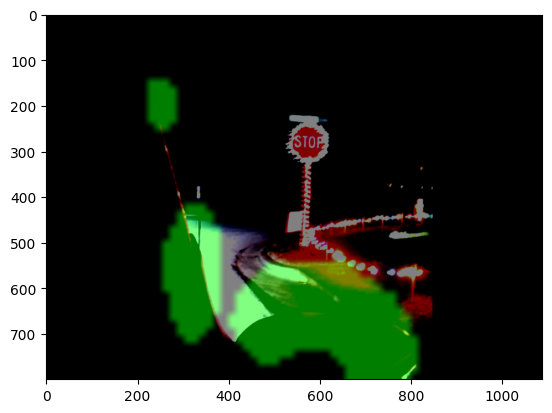

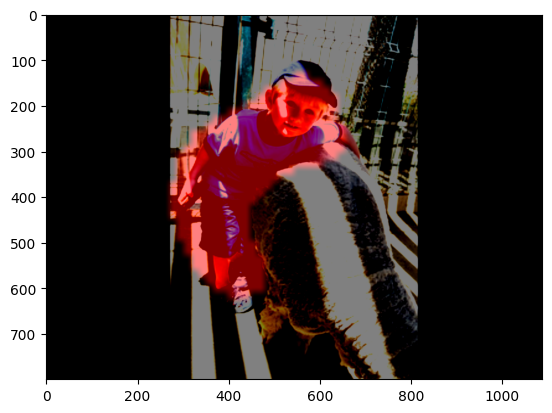

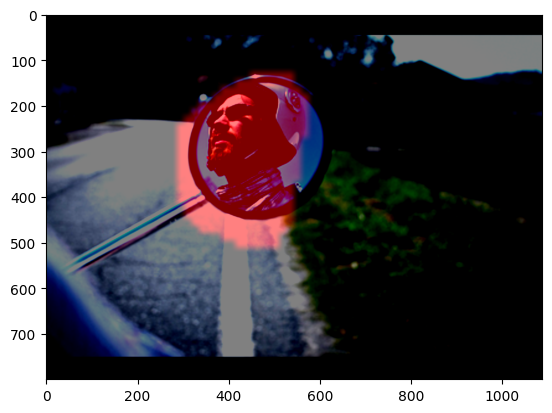

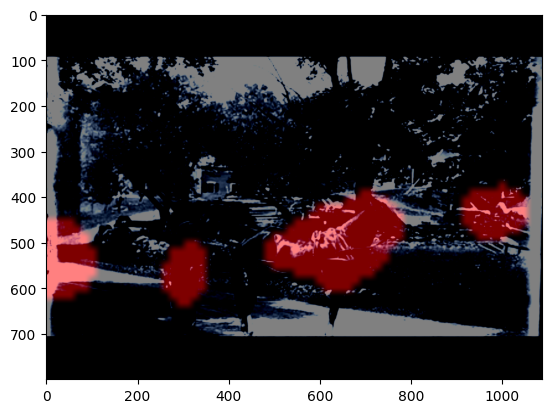

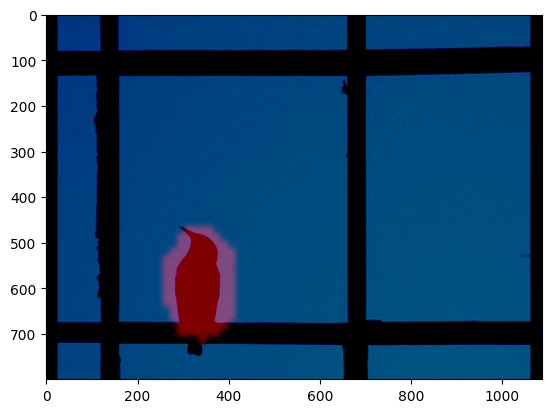

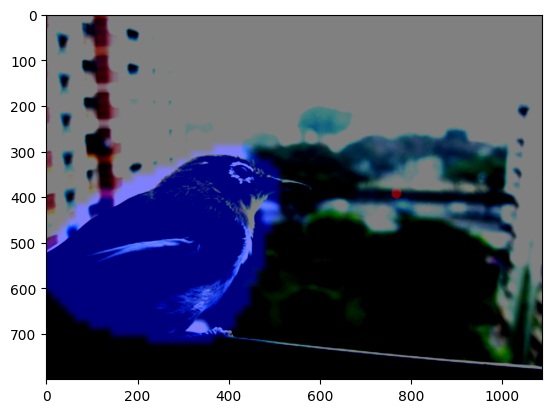

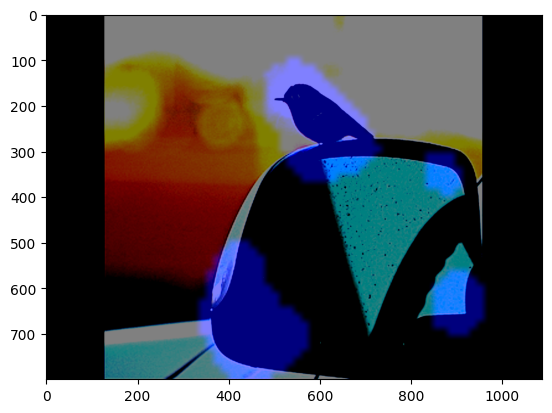

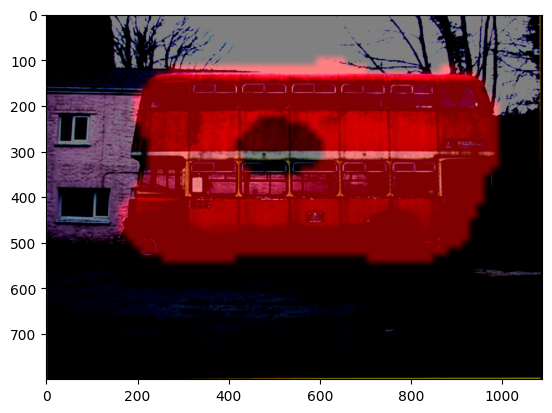

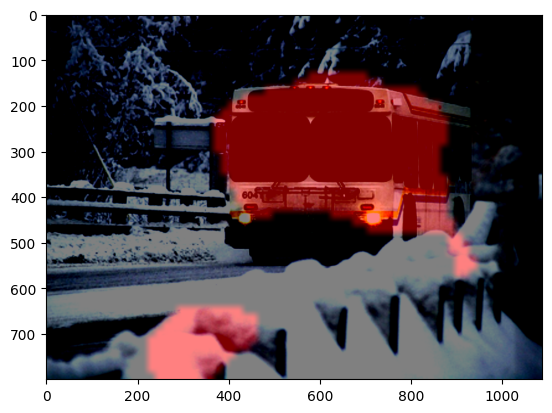

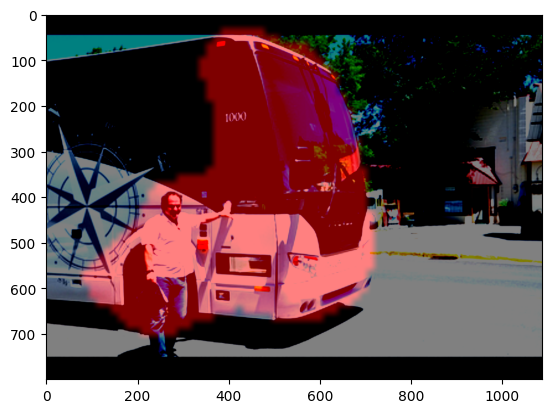

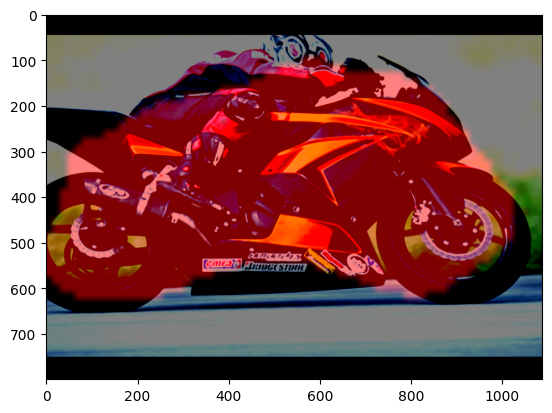

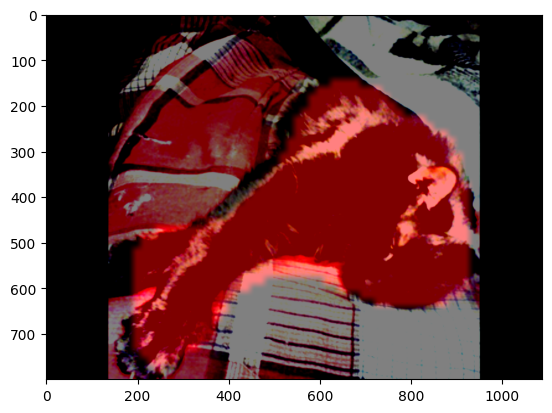

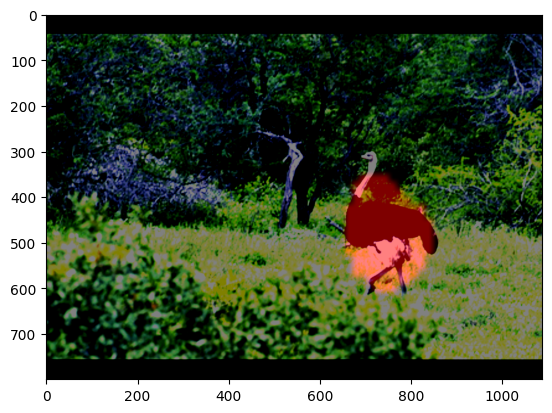

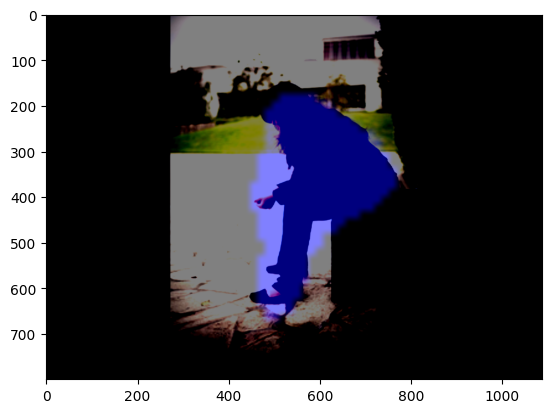

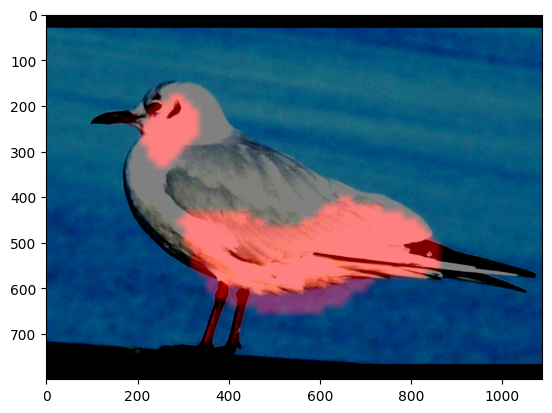

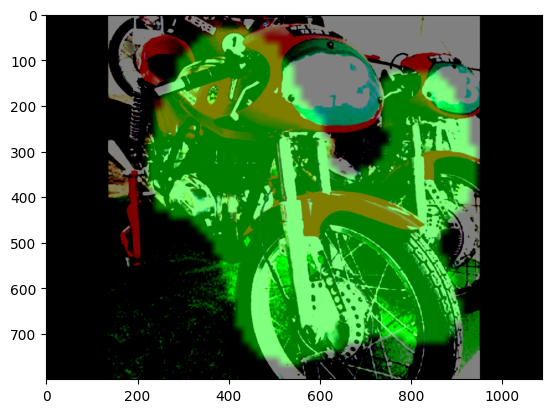

In [ ]:
image_count = len(test_batch[0])

for idx in range(image_count):
    fig_handle, axis_handle = plt.subplots()
    img_arr = test_batch[0][idx].detach().cpu().permute(1, 2, 0).numpy()
    mask_data = nms_masks[idx].unsqueeze(0)
    resized_mask = F.upsample(input=mask_data, size=(H_img, W_img), mode='bilinear', align_corners=True).squeeze(0).cpu().numpy()

    # Initializing visualization mask
    vis_mask = np.zeros_like(img_arr, dtype=np.float64)

    # Getting category and updating visualization mask
    category = nms_cats[idx]
    vis_mask[:,:,category] = resized_mask

    # Displaying image and mask overlay
    axis_handle.imshow(img_arr)
    axis_handle.imshow(vis_mask, alpha=0.5)
    plt.show()

### Training
#### Optimizer
The SGD optimizer with a weight decay of 1e-4 and a momentum of 0.9 is used. For a batch size of 16, an initial learning rate of 16 is used (this should be scaled appropriately for different batch sizes). You should train for 36 epochs, reducing the learning rate by a factor of 10 at epochs 27 and 33.

#### Data Augemnetation
To achieve better performance, you may wish to explore some data augmentation techniques. You should be able to achieve the necessary performance without any augmentation, however.

#### Checkpointing
Due to the long training time, we highly recommend that you set up regular checkpointing during your training in case your training gets interrupted (e.g. your colab session ending).

### Part B Submission
In addition to the code you used, you should submit a pdf containing the following plots:
* Dataset visualization plots such as fig. 5 and 6. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Target assignment plots such as fig. 8 and 9. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Final inference results such as figs. 11-14. You should include at least five examples and at least two examples that contain multiple objects. Additionally, the images should cover a range of scales and object classes.
* Training and validation loss curves. These should include the focal loss, dice loss, and total loss as seperate quantities.

In addition, you should include a discussion of any issues you encountered during this project and any changes you made to the siggested architecture. If you made any interesting observations or thoughts about potential improvements, you should also include them here.

* We should be able to reproduce your results with a single function call or cell evaluation. Please specify the method to do so. You do not, however, need to submit your trained weights.


### Discussion

* For this assignment, we limited our training to 15 epochs due to time constraints and challenges encountered using Colab Pro. On two occasions, we exhausted our GPU allocation, interrupting the training and debugging processes.
We believe that the model's performance could be enhanced with more training epochs. We were also interested in experimenting with data augmentation, but time constraints prevented us from implementing and testing this potential enhancement. With additional time, we're confident that further refinements could boost the model's performance.

* Another issue we faced was that the debugging was time taking. Since there are many components to this project, it took a lot of time to independently write each of them, test their functionality in accordance with one another. We used Python debugger extensively for this challenge.

* Since Colab Free GPU doesn't have many cores, we built components of our code with batch size 2 and once we had tested on 1-2 epochs, we trained our final model on batch size 16 (Colab Pro) and the optimizer parameters as given to us.

* We also used CSV Loggers and Tensorboard to store our model checkpoints and monitor our losses consistently. Since we used Colab Pro for final training, we also mounted our drive and stored our losses, checkpoints file in drive which ensured that the files were present when compute resources run out.

To execute our project:
* Import dataset.py into the active session. This will present you with visualization 5,6
*	For part b, Run the entire notebook in sequence. Please note this includes the training phase, which could be time-intensive. We have left the output code cells for you to see and have plotted the losses, inference results

In the final inference results, we see that the masks are nearly perfect, except or multi object masks. Since we were bounded by resources, we couldn't reach the perfect model. But as you see in the model loss plots, our model has been successful in reducing focal, dice, total loss over the epochs.